<a href="https://colab.research.google.com/github/ReynaldoAVZ/Scientific-Machine-Learning-7750/blob/main/Midterm-Project/Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **IMPORTANT** instruction for Problem 1: You should replace the 2D aneurysm dataset with a “spatiotemporal” dataset (scalar or vector) from your own research or lab (or an online database as explained below). Make sure you have at least 20 time-steps (ideally at least 40). If you have 3D data you can slice through it to make it 2D. You can use the aneurysm data explained below and uploaded mat file to see how to structure your data (similar to the data matrix in lectures). If you do not have any spatiotemporal data in your research group (justify why not!) then you can use the aneurysm data.

# **Bonus point** **(Data Curation)**: Online open-source datasets are ubiquitous these days. Search online to find a spatiotemporal dataset with the temporal resolution requirement above. The dataset should be related to a physical system and ideally of interest to you. Explain (document) the dataset and use it for Problem 1 below. Share the raw dataset, link to where you found it, and make it in mat format where columns are time and rows are space (similar to the sample Aneurysm dataset). 10% bonus on the exam that could be transferred to your entire course grade if you get above 100

# 1. We are given data matrix for blood flow velocity in a 2D aneurysm. The data is stored in 2D velocity vector aneu.mat. The velocity array is our typical spatiotemporal data matrix and has 3943 points and 49 time-steps (Note that this is vector data so the number of rows is 2*3943=7886). Each row first contains the x component of the velocity vector then the y component of velocity and then goes to the x and y component of the next spatial point. The coordinates array shows you the x and y coordinate position of these spatial points in the same order (useful for plotting your data). You can plot the data (e.g., velocity magnitude) using scatter plot (make sure you play with the range of colorbar to see features inside the aneurysm where the flow is very slow).

# Perform PCA (POD) on this data. Note that you can either work in vector format (no need to change the data matrix) or if you are just interested in velocity magnitude you can first pre-process the data to calculate velocity magnitude at each of the 3943 points, reduce the data matrix, and then perform PCA.

dict_keys(['__header__', '__version__', '__globals__', 'Coordinates', 'velocity'])
Coordinates shape: (3943, 2)
Velocity shape: (7886, 49)


interactive(children=(IntSlider(value=0, description='k', max=48), Output()), _dom_classes=('widget-interact',…

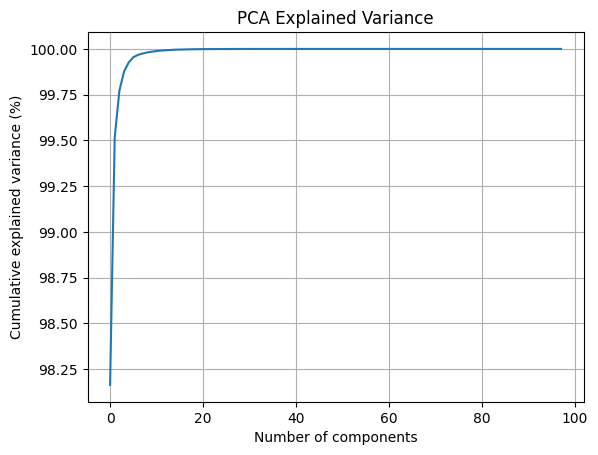

In [29]:
# import libraries
from scipy.io import loadmat
import numpy as np
from ipywidgets import interact, IntSlider

# read data file and print the variables
mat_data = loadmat('2D_velocity_vector_aneu.mat')
print(mat_data.keys())

# save coordinates (x, y) and velocity components (u, v) in separate variables
coordinates = mat_data['Coordinates']
velocity = mat_data['velocity']

# print the shapes of the variables
print('Coordinates shape:', coordinates.shape)
print('Velocity shape:', velocity.shape)

# extract x and y components of velocities (x, y, then x and y for next spatial point)
# x component of velocity is first, third, fifth, etc. columns; y component is second, fourth, sixth, etc. columns
u = velocity[0::2, :]  # x component of velocity
v = velocity[1::2, :]  # y component of velocity

# calculate magnitude of velocity vector at each point
velocity_magnitude = np.sqrt(u**2 + v**2)

import matplotlib.pyplot as plt

k = 0  # time index
x = coordinates[:, 0]
y = coordinates[:, 1]

vmin = 0
vmax = np.percentile(velocity_magnitude, 95)

def show_frame(k):
    plt.figure()
    sc = plt.scatter(x, y, c=velocity_magnitude[:, k], s=8, cmap='inferno', vmin=vmin, vmax=vmax)
    plt.colorbar(sc, label='|v|')
    plt.title(f'Velocity magnitude at time step {k}')
    plt.xlabel('x'); plt.ylabel('y')
    plt.axis('equal')
    plt.show()

interact(show_frame, k=IntSlider(min=0, max=velocity_magnitude.shape[1]-1, step=1, value=0))

# perform PCA (POD) on the velocity data
from sklearn.decomposition import PCA

# reshape velocity data to (num_points, num_time_steps*2) for PCA
num_points = coordinates.shape[0]
velocity_reshaped = velocity.reshape(num_points, -1)
pca = PCA()
pca.fit(velocity_reshaped)

# plot explained variance ratio
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance (%)')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


## (a). Plot the first three dominant modes (velocity magnitude or vector). Set the min and max of the colorbar so you see flow features inside the aneurysm. Note that in practice forvisualization, we plot over an unstructured grid not scatter points, but here we will plot on scatter points to make the process easier. However, please do investigate and see how you can improve your simple visualization based on what you find and your data.

In [31]:
# plot the first three dominant modes (velocity magnitude). Set min and max of colorbar to see flow features
def show_mode(mode):
    plt.figure()
    mode_velocity = pca.components_[mode].reshape(num_points, 2)  # reshape back to (num_points, 2)
    mode_magnitude = np.sqrt(mode_velocity[:, 0]**2 + mode_velocity[:, 1]**2)
    sc = plt.scatter(x, y, c=mode_magnitude, s=8, cmap='inferno', vmin=vmin, vmax=vmax)
    plt.colorbar(sc, label='|v|')
    plt.title(f'PCA Mode {mode+1}')
    plt.xlabel('x'); plt.ylabel('y')
    plt.axis('equal')
    plt.show()
interact(show_mode, mode=IntSlider(min=0, max=2, step=1, value=0))


<Figure size 640x480 with 0 Axes>

interactive(children=(IntSlider(value=0, description='mode', max=2), Output()), _dom_classes=('widget-interact…

<function __main__.show_mode(mode)>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## (b). Corrupt your data in two different approaches: 1- Adding noise randomly to 80% of your data. 2- Adding noise to a local specific region (use coordinates to know the location). When you add noise you generate a random number with zero mean and standard deviation 1 from a Gaussian distribution, then you modify each data entry as: xnoisy = x+ζ∗rand∗x, where rand is the random number you generated and ζ is the level of noise. Play with different noise levels (0.05, 0.1, 0.2, etc.). As an example, ζ = 0.1 is adding 10% noise (we disturb the data by around 10% of its value with some randomness). Similar to the lecture 9 plots, for each noise level and pattern you investigated plot the singular values sorted versus mode as well as the cumulative energy (for each mode this is the sum of all singular values up to that mode normalized by the sum of all singular values). Comment on what you learn.

## (c). Perform RPCA and repeat the above to see how RPCA improves your results under noise (you might need to play with the hyperparameter λ in RPCA). Report on RPCA’s performance based on noise level and pattern (random vs. localized)

# 2. Assume we have time-series data that we can represent as a Fourier series. We can define such a signal as:
# u(t) = aₒ + ∑aᵢ* cos(iωt) + ∑bᵢ*sin(iωt)

# Define such a signal with N=3. You may arbitrary select the coefficients as well as the frequency ω. Generate the signal for 0 < t < T and ensure you have a high enough resolution. Select T such that your data contains a few of the periods. This is your ground-truth data that you can use for calculating your data reconstruction accuracy below.


## (a) Now imagine you are an experimentalist collecting u(t) data but you cannot measure u(t) at high resolution. You can only collect p points with p sensors where p is not a very large number (if you just plot this data with these p measurements your curve will look terrible compared to ground truth). Use compressed sensing (maybe discrete cosine transform as your sparsifying transform) to reconstruct high resolution data (same resolution as ground-truth) based on your p measurements. How low can you make p and still get good results? How does this depend on the frequency of your signal (if you make frequency higher do you need more sensors?) Please show all of your results and discuss your findings.

## (b) Now consider the data with just one period (define T to be equal to one period). Does your method still work?

## (c) Now add noise to your signal in part (a) similar to last example. How robust are your results based on the level of noise? Implement the optimization formulation we discussed in class that is more robust to noise to see how that improves your results.